In [1]:
#load python require packages
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D #load CNN classes
from keras.models import Sequential, load_model
from keras.models import model_from_json
import pickle
from sklearn.model_selection import train_test_split 
from keras_dgl.layers import GraphCNN #load Graph CNN class
import keras.backend as K
from keras.regularizers import l2

import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.
c:\users\hello\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\hello\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\hello\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
path = 'Dataset'
labels = ['Caries', 'Disease', 'Gingivitis', 'Normal', 'ToothDiscoloration', 'Ulcer']
def getID(name):
    index = 0
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index 

In [3]:
precision = []
recall = []
fscore = []
accuracy = []


Total images found in dataset : 2057
Total Normal images found in dataset : 219
Total Infected (Disease) images found in dataset : 454



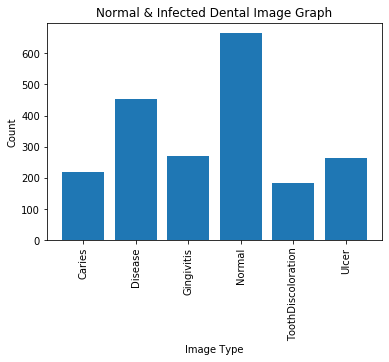

In [4]:
X = []
Y = []
if os.path.exists("model/X.txt.npy"):
    X = np.load('model/X.txt.npy') #load X and Y data
    Y = np.load('model/Y.txt.npy')
else:
    for root, dirs, directory in os.walk(path):#loop all images in dataset folder
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j]) #read each image one by one
                img = cv2.resize(img, (32,32)) #resize image
                im2arr = np.array(img)
                im2arr = (32,32,3)#resize image as color images by using 3 colours such as RGB
                label = getID(name)#get the label of the image
                X.append(im2arr) #add image to array as X features
                Y.append(label) #add label to Y array
    X = np.asarray(X) #convert images to numpy array
    Y = np.asarray(Y)     
    np.save('model/X.txt',X) #save X and Y values
    np.save('model/Y.txt',Y)
classes, count = np.unique(Y, return_counts = True) #find normal and disease images count
print()
print("Total images found in dataset : "+str(X.shape[0]))
print("Total Normal images found in dataset : "+str(count[0]))
print("Total Infected (Disease) images found in dataset : "+str(count[1]))
print()

height = count
bars = labels
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Image Type")
plt.ylabel("Count")
plt.title("Normal & Infected Dental Image Graph")#show graph with normal and disease images count
plt.xticks(rotation=90)
plt.rcParams["figure.figsize"]= [6,6]
plt.rcParams["figure.figsize"]= [6,6]
plt.show()

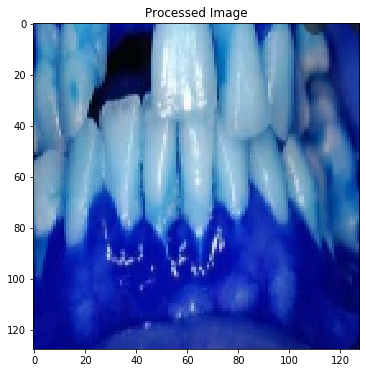

[[[[0.34117648 0.34117648 0.34117648]
   [0.34509805 0.34509805 0.34509805]
   [0.4        0.4        0.4       ]
   ...
   [0.80784315 0.80784315 0.80784315]
   [0.8156863  0.8156863  0.8156863 ]
   [0.87058824 0.87058824 0.87058824]]

  [[0.40392157 0.40392157 0.40392157]
   [0.42352942 0.42352942 0.42352942]
   [0.3882353  0.3882353  0.3882353 ]
   ...
   [0.8156863  0.8156863  0.8156863 ]
   [0.8        0.8        0.8       ]
   [0.87058824 0.87058824 0.87058824]]

  [[0.2509804  0.2509804  0.2509804 ]
   [0.30980393 0.30980393 0.30980393]
   [0.45490196 0.45490196 0.45490196]
   ...
   [0.83137256 0.83137256 0.83137256]
   [0.80784315 0.80784315 0.80784315]
   [0.8627451  0.8627451  0.8627451 ]]

  ...

  [[1.         1.         1.        ]
   [1.         1.         1.        ]
   [1.         1.         1.        ]
   ...
   [0.21960784 0.21960784 0.21960784]
   [0.23137255 0.23137255 0.23137255]
   [0.23921569 0.23921569 0.23921569]]

  [[1.         1.         1.        ]
   [1. 

In [5]:
#images preprocessing and features extraction
X = X.astype('float32')
X = X/255 #normalizing images    
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffling the dataset images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)

img = cv2.imread("Dataset/Gingivitis/(27).jpg")
img = img / 255
img = cv2.resize(img, (128, 128))
plt.imshow(img)
plt.title('Processed Image')
plt.show()

print(X)
print (Y)

In [6]:
#Calculate accuracy and other metrics
#function to calculate various metrics such as accuracy, precision etc
def calculateMetrics(algorithm, predict, testY):
    p = precision_score(testY, predict,average='macro') * 100
    r = recall_score(testY, predict,average='macro') * 100
    f = f1_score(testY, predict,average='macro') * 100
    a = accuracy_score(testY,predict)*100 
    print()
    print(algorithm+' Accuracy  : '+str(a))
    print(algorithm+' Precision   : '+str(p))
    print(algorithm+' Recall      : '+str(r))
    print(algorithm+' FMeasure    : '+str(f))
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    conf_matrix = confusion_matrix(testY, predict) 
    plt.figure(figsize =(6, 6)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()

In [7]:
#splitting dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
print()
print("80% images used for training & 20% images used for testing")
print("Training Images Size : "+str(X_train.shape[0]))
print("Testing Images Size  : "+str(X_test.shape[0]))
print()
print(X_train.shape)
print(y_train.shape)


80% images used for training & 20% images used for testing
Training Images Size : 1645
Testing Images Size  : 412

(1645, 32, 32, 3)
(1645, 6)


In [8]:
from keras.callbacks import ModelCheckpoint 
#train & load CNN model
cnn = Sequential()#define sequential object
#define CNN layer with 32 filters
cnn.add(Convolution2D(32, (3, 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Convolution2D(32, (3, 3), activation = 'relu'))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(units = 256, activation = 'relu'))
cnn.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile the model
cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#start training model
if os.path.exists("model/model_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/model_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn.fit(X_train, y_train, batch_size=16, epochs=25, validation_data = (X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn.load_weights("model/model_weights.hdf5")
print(cnn.summary())    


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               295168    
_________________________________________________________________
dense_2 (Dense)              (None, 6)               



CNN Classification Result on Dental Dataset Accuracy  : 95.63106796116504
CNN Classification Result on Dental Dataset Precision   : 95.762609669067
CNN Classification Result on Dental Dataset Recall      : 96.05980043296402
CNN Classification Result on Dental Dataset FMeasure    : 95.8633506807432


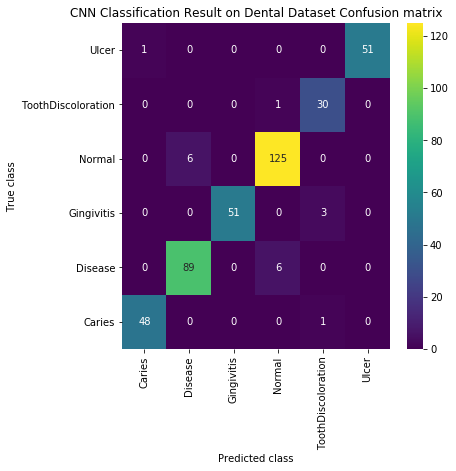

In [9]:
#perform prediction using CNN algortihm and then call metrics function to calculate accuracy and other values
predict = cnn.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)  
calculateMetrics("CNN Classification Result on Dental Dataset", predict, y_test1)

In [10]:
print(X.shape)

(2057, 32, 32, 3)


In [11]:
#training Graph CNN Algorithm
X1 = np.reshape(X, (X.shape[0], (X.shape[1] * X.shape[2] * X.shape[3])))
print(X1.shape)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y, test_size=0.2)
print(X_train.shape)
print(y_train.shape)

graph_conv_filters = np.eye(32)
graph_conv_filters = K.constant(graph_conv_filters)
graph_cnn = Sequential() 
#defining graph cnn layer with 128 filters
graph_cnn.add(GraphCNN(128, 1, graph_conv_filters, input_shape=(X_train1.shape[1],), activation='elu', kernel_regularizer=l2(5e-4)))
#defining another layer with 64 layer
graph_cnn.add(GraphCNN(64, 1, graph_conv_filters, input_shape=(X_train1.shape[1],), activation='elu', kernel_regularizer=l2(5e-4)))
#graph_cnn.add(Dense(units = 256, activation = 'relu'))
graph_cnn.add(GraphCNN(32, 1, graph_conv_filters, input_shape=(X_train1.shape[1],), activation='elu', kernel_regularizer=l2(5e-4)))
graph_cnn.add(Dense(units = 256, activation = 'relu'))
#add the output layer
graph_cnn.add(Dense(units = y_train1.shape[1], activation = 'softmax'))
#compile the model
graph_cnn.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
#train the model
print(graph_cnn.summary())
if os.path.exists("model/graph_model_weights.hdf5") == False:
    hist = graph_cnn.fit(X_train1, y_train1, batch_size=32, epochs=25, shuffle=True, verbose=2, validation_data = (X_test1, y_test1))
    graph_cnn.save_weights('model/graph_model_weights.h5')            
    f = open('model/graph_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    graph_cnn = load_model("model/graph_model_weights.hdf5", compile=False) 

(2057, 3072)
(1645, 32, 32, 3)
(1645, 6)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_cnn_1 (GraphCNN)       (None, 128)               4224      
_________________________________________________________________
graph_cnn_2 (GraphCNN)       (None, 64)                8256      
_________________________________________________________________
graph_cnn_3 (GraphCNN)       (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               8448      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 1542      
Total params: 24,550
Trainable params: 24,550
Non-trainable params: 0
_________________________________________________________________
None



Graph CNN Classification Result on Dental Dataset Accuracy  : 99.51456310679612
Graph CNN Classification Result on Dental Dataset Precision   : 99.57070707070707
Graph CNN Classification Result on Dental Dataset Recall      : 99.28692699490661
Graph CNN Classification Result on Dental Dataset FMeasure    : 99.42231597984362


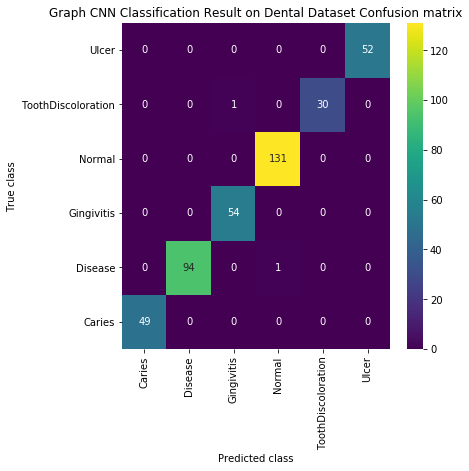

In [12]:
#perfrom prediction using Graph CNN and then calculate accuracy and precision
global graph_cnn
predict = graph_cnn.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test = np.argmax(y_test, axis=1)  
calculateMetrics("Graph CNN Classification Result on Dental Dataset", predict, y_test)

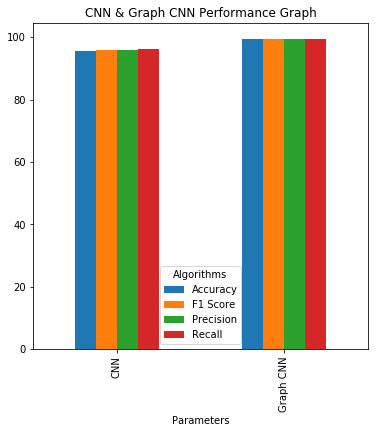

In [13]:
#display comparison graph of CNN and Graph CNN
df = pd.DataFrame([['CNN','Precision',precision[0]],['CNN','Recall',recall[0]],['CNN','F1 Score',fscore[0]],['CNN','Accuracy',accuracy[0]],
                   ['Graph CNN','Precision',precision[1]],['Graph CNN','Recall',recall[1]],['Graph CNN','F1 Score',fscore[1]],['Graph CNN','Accuracy',accuracy[1]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar')
plt.title("CNN & Graph CNN Performance Graph")
plt.show()

In [14]:
#display accuracy and other metrics in tabular format
columns = ["Algorithm Name","Precison","Recall","FScore","Accuracy"]
values = []
algorithm_names = ["CNN","Graph CNN"]
for i in range(len(algorithm_names)):
    values.append([algorithm_names[i],precision[i],recall[i],fscore[i],accuracy[i]])
    
temp = pd.DataFrame(values,columns=columns)
display(temp)

,Algorithm Name,Precison,Recall,FScore,Accuracy
0,CNN,95.762610,96.059800,95.863351,95.631068
1,Graph CNN,99.570707,99.286927,99.422316,99.514563


In [ ]:
#load GUI packages
from tkinter import messagebox
from tkinter import *
from tkinter import simpledialog
import tkinter
from tkinter import filedialog
from tkinter.filedialog import askopenfilename

main = tkinter.Tk()
main.title("Dental Disease Classification using CNN & Graph CNN") 
main.geometry("1000x400")

#function to perform prediction
def predict():
    filename = filedialog.askopenfilename(initialdir="testImages")
    image = cv2.imread(filename)
    img = cv2.resize(image, (32,32))
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3)
    img = np.asarray(im2arr)
    img = img.astype('float32')
    img = img/255
    preds = graph_cnn.predict(img)
    predict = np.argmax(preds)
    score = np.amax(preds)
    img = cv2.imread(filename)
    img = cv2.resize(img, (600,400))
    cv2.putText(img, 'Classification Result: '+labels[predict]+" Detected", (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 0, 0), 2)
    cv2.imshow('Classification Result: '+labels[predict]+" Detected", img)
    cv2.waitKey(0)
    
font = ('times', 16, 'bold')
title = Label(main, text='Dental Disease Classification using CNN & Graph CNN',justify=LEFT)
title.config(bg='firebrick4', fg='dodger blue')  
title.config(font=font)           
title.config(height=3, width=100)       
title.place(x=0,y=5)    
font1 = ('times', 12, 'bold')
predictButton = Button(main, text="Predict Disease from Test Image", command=predict, bg='#ffb3fe')
predictButton.place(x=450,y=100)
predictButton.config(font=font1) 

main.config(bg='LightSalmon3')
main.mainloop()

In [ ]:
from flask import Flask, render_template, request,url_for
import cv2
import numpy as np
from tensorflow.keras.models import load_model
import os
from werkzeug.utils import secure_filename

app = Flask(__name__,template_folder='templates')
app.config['SECRET_KEY'] = 'your_secret_key_here'


@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        # get the uploaded image file from the form
        graph_cnn = load_model("model/graph_model_weights.hdf5") 
        file = request.files['image']
        if file:
            filename = secure_filename(file.filename)
            # create the directory if it does not exist
            os.makedirs('static/uploads', exist_ok=True)
            file_path = os.path.join('static/uploads', filename)
            file.save(file_path)
            image = cv2.imread(file_path)
            img = cv2.resize(image, (32,32))
            im2arr = np.array(img)
            im2arr = im2arr.reshape(1,32,32,3)
            img = np.asarray(im2arr)
            img = img.astype('float32')
            img = img/255
            preds = graph_cnn.predict(img)
            predict = np.argmax(preds)
            score = np.amax(preds)
            label = labels[predict]
            # generate URL for uploaded image file
            image_url = url_for('static', filename=f'uploads/{filename}')
            return render_template('result.html', label=label, score=score,image_url=image_url)
    return render_template('index.html')

if __name__ == '__main__':
    app.run(debug=False)
